Disentangled representations with $\beta$-VAE and forced learning of some traits for Radio Galaxies

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm

In [2]:
from rg_dataset import LRG, UNLRG, UNLRG_C

In [3]:
lrg_data_set = LRG(use_kittler=True)
unlrg_data_set = UNLRG_C(use_kittler=True)

LRG:	1442/1442
LRG:	14245/14245


In [4]:
data_loader_lrg   = data.DataLoader(lrg_data_set, batch_size=128, shuffle=False)
data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=128, shuffle=False)

sample = iter(data_loader_lrg).next()

In [5]:
#Simple Variational Auto Encoder
class VAE(nn.Module):
    def __init__(self, lt_dim=10):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 64, 128, 256]
        encoder_layers = []
        decoder_layers = []
        
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            encoder_layers.append(nn.ReLU())
        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            decoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Linear(self.k[-1]*2*2, lt_dim)
        self.fc_ep = nn.Linear(self.k[-1]*2*2, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [6]:
class B_VAE_Loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
#         self.recon_ls = nn.MSELoss(reduction='sum')
        self.recon_ls = nn.BCELoss(reduction='sum')
        #self.recon_ls = nn.BCEWithLogitsLoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

In [7]:
device = 'cuda'
epochs = 1000
vae = VAE().to(device)
beta_vae_loss = B_VAE_Loss(gamma=20, max_capacity=20, epochs=epochs)
optimizer = Adam(vae.parameters(), lr=0.001)

In [8]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        extended = target > 1
        extended = Variable(extended.float().to(device), requires_grad=False)
        pred_ext = torch.sigmoid(output[1][:,0])
        ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        #########       FRI vs FRII         #########
        o = torch.sigmoid(output[1][:, 1])[target > 1]
        c = target[target > 1]
        o = o[c < 4]
        c = c[c < 4]
        c = Variable( (c == 3).float().to(device), requires_grad=False)
        fr_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        #########   Regular vs Irregular   #########
        o = torch.sigmoid(output[1][:, 2])[target > 1]
        c = target[target > 1]
#         o = o[c < 4]
        c = c < 4
        c = Variable( c.float().to(device), requires_grad=False)
        reg_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss + 10 * (ext_loss + fr_loss + reg_loss)
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:10.4f}\tR_Loss: {:10.4f}\tCapacity: {:10.4f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [9]:
def train_step_unlrg(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:10.4f}\tR_Loss: {:10.4f}\tCapacity: {:10.4f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [10]:
beta_vae_loss = B_VAE_Loss(gamma=20, max_capacity=20, epochs=epochs)
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    s = train_step(vae, 'cuda', data_loader_lrg, optimizer, epoch)
    t = time.time() - start
    sys.stdout.write('{0}\tTime {1:.2f}s\n'.format(s, t))
    beta_vae_loss.update()

Train Epoch: 1 [9408/14420 (99%)]	Loss:   323.2146	R_Loss:   302.4052	Capacity:     0.0000	Time 8.78s
Train Epoch: 2 [9408/14420 (99%)]	Loss:   290.3558	R_Loss:   260.2650	Capacity:     0.0200	Time 7.77s
Train Epoch: 3 [9408/14420 (99%)]	Loss:   285.7870	R_Loss:   256.8034	Capacity:     0.0400	Time 7.74s
Train Epoch: 4 [9408/14420 (99%)]	Loss:   288.3465	R_Loss:   257.8019	Capacity:     0.0600	Time 7.75s
Train Epoch: 5 [9408/14420 (99%)]	Loss:   287.3135	R_Loss:   257.9905	Capacity:     0.0800	Time 7.74s
Train Epoch: 6 [9408/14420 (99%)]	Loss:   281.0797	R_Loss:   251.3742	Capacity:     0.1000	Time 7.64s
Train Epoch: 7 [9408/14420 (99%)]	Loss:   281.6921	R_Loss:   249.7578	Capacity:     0.1200	Time 7.81s
Train Epoch: 8 [9408/14420 (99%)]	Loss:   285.5083	R_Loss:   255.0995	Capacity:     0.1400	Time 7.86s
Train Epoch: 9 [9408/14420 (99%)]	Loss:   280.0501	R_Loss:   247.2025	Capacity:     0.1600	Time 7.78s
Train Epoch: 10 [9408/14420 (99%)]	Loss:   284.9761	R_Loss:   249.8761	Capacity:  

Train Epoch: 80 [9408/14420 (99%)]	Loss:   241.0358	R_Loss:   209.7223	Capacity:     1.5800	Time 7.71s
Train Epoch: 81 [9408/14420 (99%)]	Loss:   245.6161	R_Loss:   207.5788	Capacity:     1.6000	Time 7.65s
Train Epoch: 82 [9408/14420 (99%)]	Loss:   247.3559	R_Loss:   208.6317	Capacity:     1.6200	Time 7.68s
Train Epoch: 83 [9408/14420 (99%)]	Loss:   245.3960	R_Loss:   208.3467	Capacity:     1.6400	Time 7.71s
Train Epoch: 84 [9408/14420 (99%)]	Loss:   244.2073	R_Loss:   211.1120	Capacity:     1.6600	Time 7.69s
Train Epoch: 85 [9408/14420 (99%)]	Loss:   239.7801	R_Loss:   207.9367	Capacity:     1.6800	Time 7.68s
Train Epoch: 86 [9408/14420 (99%)]	Loss:   246.0217	R_Loss:   217.8196	Capacity:     1.7000	Time 7.69s
Train Epoch: 87 [9408/14420 (99%)]	Loss:   244.3962	R_Loss:   215.4322	Capacity:     1.7200	Time 7.66s
Train Epoch: 88 [9408/14420 (99%)]	Loss:   244.9756	R_Loss:   209.3943	Capacity:     1.7400	Time 7.65s
Train Epoch: 89 [9408/14420 (99%)]	Loss:   244.8970	R_Loss:   217.5456	Ca

Train Epoch: 159 [9408/14420 (99%)]	Loss:   217.2204	R_Loss:   202.3552	Capacity:     3.1600	Time 7.66s
Train Epoch: 160 [9408/14420 (99%)]	Loss:   220.8100	R_Loss:   200.1247	Capacity:     3.1800	Time 7.63s
Train Epoch: 161 [9408/14420 (99%)]	Loss:   220.6834	R_Loss:   201.0074	Capacity:     3.2000	Time 7.65s
Train Epoch: 162 [9408/14420 (99%)]	Loss:   215.9320	R_Loss:   194.2670	Capacity:     3.2200	Time 7.64s
Train Epoch: 163 [9408/14420 (99%)]	Loss:   217.5102	R_Loss:   199.5416	Capacity:     3.2400	Time 7.64s
Train Epoch: 164 [9408/14420 (99%)]	Loss:   212.9786	R_Loss:   197.2126	Capacity:     3.2600	Time 7.71s
Train Epoch: 165 [9408/14420 (99%)]	Loss:   220.9019	R_Loss:   190.9622	Capacity:     3.2800	Time 7.70s
Train Epoch: 166 [9408/14420 (99%)]	Loss:   215.1219	R_Loss:   196.3025	Capacity:     3.3000	Time 7.71s
Train Epoch: 167 [9408/14420 (99%)]	Loss:   213.0153	R_Loss:   195.1729	Capacity:     3.3200	Time 7.68s
Train Epoch: 168 [9408/14420 (99%)]	Loss:   217.3253	R_Loss:   1

Train Epoch: 237 [9408/14420 (99%)]	Loss:   201.5430	R_Loss:   188.2368	Capacity:     4.7200	Time 7.73s
Train Epoch: 238 [9408/14420 (99%)]	Loss:   204.2652	R_Loss:   190.2018	Capacity:     4.7400	Time 7.72s
Train Epoch: 239 [9408/14420 (99%)]	Loss:   199.2993	R_Loss:   186.1771	Capacity:     4.7600	Time 7.74s
Train Epoch: 240 [9408/14420 (99%)]	Loss:   209.2346	R_Loss:   185.4181	Capacity:     4.7800	Time 7.84s
Train Epoch: 241 [9408/14420 (99%)]	Loss:   201.5609	R_Loss:   185.7527	Capacity:     4.8000	Time 7.85s
Train Epoch: 242 [9408/14420 (99%)]	Loss:   198.2130	R_Loss:   182.5606	Capacity:     4.8200	Time 7.72s
Train Epoch: 243 [9408/14420 (99%)]	Loss:   204.4262	R_Loss:   185.0774	Capacity:     4.8400	Time 7.73s
Train Epoch: 244 [9408/14420 (99%)]	Loss:   201.1779	R_Loss:   184.0005	Capacity:     4.8600	Time 7.71s
Train Epoch: 245 [9408/14420 (99%)]	Loss:   203.8288	R_Loss:   187.5967	Capacity:     4.8800	Time 7.70s
Train Epoch: 246 [9408/14420 (99%)]	Loss:   203.5137	R_Loss:   1

Train Epoch: 315 [9408/14420 (99%)]	Loss:   190.7505	R_Loss:   179.5314	Capacity:     6.2800	Time 7.68s
Train Epoch: 316 [9408/14420 (99%)]	Loss:   202.3327	R_Loss:   177.6115	Capacity:     6.3000	Time 7.68s
Train Epoch: 317 [9408/14420 (99%)]	Loss:   202.0959	R_Loss:   175.3653	Capacity:     6.3200	Time 7.71s
Train Epoch: 318 [9408/14420 (99%)]	Loss:   203.6639	R_Loss:   175.2858	Capacity:     6.3400	Time 7.70s
Train Epoch: 319 [9408/14420 (99%)]	Loss:   192.6278	R_Loss:   175.3746	Capacity:     6.3600	Time 7.71s
Train Epoch: 320 [9408/14420 (99%)]	Loss:   194.7400	R_Loss:   174.6116	Capacity:     6.3800	Time 7.68s
Train Epoch: 321 [9408/14420 (99%)]	Loss:   198.2299	R_Loss:   177.2251	Capacity:     6.4000	Time 7.68s
Train Epoch: 322 [9408/14420 (99%)]	Loss:   190.1596	R_Loss:   177.6374	Capacity:     6.4200	Time 7.66s
Train Epoch: 323 [9408/14420 (99%)]	Loss:   190.2767	R_Loss:   176.4210	Capacity:     6.4400	Time 7.67s
Train Epoch: 324 [9408/14420 (99%)]	Loss:   195.4193	R_Loss:   1

Train Epoch: 393 [9408/14420 (99%)]	Loss:   192.4084	R_Loss:   173.0342	Capacity:     7.8400	Time 7.66s
Train Epoch: 394 [9408/14420 (99%)]	Loss:   185.2498	R_Loss:   169.4001	Capacity:     7.8600	Time 7.68s
Train Epoch: 395 [9408/14420 (99%)]	Loss:   184.4033	R_Loss:   171.3788	Capacity:     7.8800	Time 7.67s
Train Epoch: 396 [9408/14420 (99%)]	Loss:   188.3400	R_Loss:   170.8504	Capacity:     7.9000	Time 7.66s
Train Epoch: 397 [9408/14420 (99%)]	Loss:   182.2448	R_Loss:   171.0375	Capacity:     7.9200	Time 7.67s
Train Epoch: 398 [9408/14420 (99%)]	Loss:   188.7139	R_Loss:   172.6998	Capacity:     7.9400	Time 7.67s
Train Epoch: 399 [9408/14420 (99%)]	Loss:   187.5971	R_Loss:   171.5853	Capacity:     7.9600	Time 7.66s
Train Epoch: 400 [9408/14420 (99%)]	Loss:   188.0085	R_Loss:   170.1998	Capacity:     7.9800	Time 7.67s
Train Epoch: 401 [9408/14420 (99%)]	Loss:   188.0845	R_Loss:   171.1269	Capacity:     8.0000	Time 7.68s
Train Epoch: 402 [9408/14420 (99%)]	Loss:   187.7900	R_Loss:   1

Train Epoch: 471 [9408/14420 (99%)]	Loss:   180.0368	R_Loss:   168.5196	Capacity:     9.4000	Time 7.72s
Train Epoch: 472 [9408/14420 (99%)]	Loss:   182.0193	R_Loss:   166.4304	Capacity:     9.4200	Time 7.73s
Train Epoch: 473 [9408/14420 (99%)]	Loss:   188.8681	R_Loss:   168.0052	Capacity:     9.4400	Time 7.77s
Train Epoch: 474 [9408/14420 (99%)]	Loss:   191.1713	R_Loss:   165.0810	Capacity:     9.4600	Time 7.73s
Train Epoch: 475 [9408/14420 (99%)]	Loss:   183.7860	R_Loss:   167.6841	Capacity:     9.4800	Time 7.70s
Train Epoch: 476 [9408/14420 (99%)]	Loss:   187.8728	R_Loss:   167.5384	Capacity:     9.5000	Time 7.69s
Train Epoch: 477 [9408/14420 (99%)]	Loss:   184.3143	R_Loss:   166.0460	Capacity:     9.5200	Time 7.73s
Train Epoch: 478 [9408/14420 (99%)]	Loss:   177.4224	R_Loss:   167.4523	Capacity:     9.5400	Time 7.72s
Train Epoch: 479 [9408/14420 (99%)]	Loss:   178.8436	R_Loss:   168.5998	Capacity:     9.5600	Time 7.76s
Train Epoch: 480 [9408/14420 (99%)]	Loss:   187.6739	R_Loss:   1

Train Epoch: 549 [9408/14420 (99%)]	Loss:   177.3201	R_Loss:   162.3695	Capacity:    10.9600	Time 7.74s
Train Epoch: 550 [9408/14420 (99%)]	Loss:   175.9972	R_Loss:   162.6686	Capacity:    10.9800	Time 7.69s
Train Epoch: 551 [9408/14420 (99%)]	Loss:   170.9937	R_Loss:   161.6513	Capacity:    11.0000	Time 7.68s
Train Epoch: 552 [9408/14420 (99%)]	Loss:   174.4947	R_Loss:   163.9116	Capacity:    11.0200	Time 7.67s
Train Epoch: 553 [9408/14420 (99%)]	Loss:   179.8465	R_Loss:   164.6044	Capacity:    11.0400	Time 7.72s
Train Epoch: 554 [9408/14420 (99%)]	Loss:   179.3104	R_Loss:   163.0801	Capacity:    11.0600	Time 7.80s
Train Epoch: 555 [9408/14420 (99%)]	Loss:   177.3025	R_Loss:   162.5051	Capacity:    11.0800	Time 7.76s
Train Epoch: 556 [9408/14420 (99%)]	Loss:   180.4146	R_Loss:   161.8398	Capacity:    11.1000	Time 7.77s
Train Epoch: 557 [9408/14420 (99%)]	Loss:   177.0069	R_Loss:   165.4823	Capacity:    11.1200	Time 7.78s
Train Epoch: 558 [9408/14420 (99%)]	Loss:   179.1712	R_Loss:   1

Train Epoch: 627 [9408/14420 (99%)]	Loss:   170.5152	R_Loss:   161.8916	Capacity:    12.5200	Time 7.67s
Train Epoch: 628 [9408/14420 (99%)]	Loss:   180.5571	R_Loss:   159.0742	Capacity:    12.5400	Time 7.66s
Train Epoch: 629 [9408/14420 (99%)]	Loss:   180.3424	R_Loss:   163.4196	Capacity:    12.5600	Time 7.69s
Train Epoch: 630 [9408/14420 (99%)]	Loss:   170.8340	R_Loss:   161.9796	Capacity:    12.5800	Time 7.76s
Train Epoch: 631 [9408/14420 (99%)]	Loss:   182.8708	R_Loss:   161.6032	Capacity:    12.6000	Time 7.67s
Train Epoch: 632 [9408/14420 (99%)]	Loss:   176.8083	R_Loss:   160.3017	Capacity:    12.6200	Time 7.70s
Train Epoch: 633 [9408/14420 (99%)]	Loss:   172.2982	R_Loss:   162.3880	Capacity:    12.6400	Time 7.83s
Train Epoch: 634 [9408/14420 (99%)]	Loss:   168.9425	R_Loss:   160.1259	Capacity:    12.6600	Time 7.73s
Train Epoch: 635 [9408/14420 (99%)]	Loss:   172.8693	R_Loss:   160.7039	Capacity:    12.6800	Time 7.70s
Train Epoch: 636 [9408/14420 (99%)]	Loss:   167.1718	R_Loss:   1

Train Epoch: 705 [9408/14420 (99%)]	Loss:   171.2246	R_Loss:   156.0358	Capacity:    14.0800	Time 7.66s
Train Epoch: 706 [9408/14420 (99%)]	Loss:   169.1527	R_Loss:   157.1483	Capacity:    14.1000	Time 7.64s
Train Epoch: 707 [9408/14420 (99%)]	Loss:   164.8118	R_Loss:   156.5351	Capacity:    14.1200	Time 7.64s
Train Epoch: 708 [9408/14420 (99%)]	Loss:   171.4953	R_Loss:   159.3201	Capacity:    14.1400	Time 7.66s
Train Epoch: 709 [9408/14420 (99%)]	Loss:   169.1887	R_Loss:   157.6014	Capacity:    14.1600	Time 7.66s
Train Epoch: 710 [9408/14420 (99%)]	Loss:   165.7698	R_Loss:   158.2625	Capacity:    14.1800	Time 7.66s
Train Epoch: 711 [9408/14420 (99%)]	Loss:   166.7428	R_Loss:   157.6889	Capacity:    14.2000	Time 7.66s
Train Epoch: 712 [9408/14420 (99%)]	Loss:   171.7637	R_Loss:   158.2017	Capacity:    14.2200	Time 7.70s
Train Epoch: 713 [9408/14420 (99%)]	Loss:   167.0821	R_Loss:   156.9649	Capacity:    14.2400	Time 7.72s
Train Epoch: 714 [9408/14420 (99%)]	Loss:   170.5981	R_Loss:   1

Train Epoch: 783 [9408/14420 (99%)]	Loss:   170.8452	R_Loss:   154.8259	Capacity:    15.6400	Time 7.70s
Train Epoch: 784 [9408/14420 (99%)]	Loss:   175.0872	R_Loss:   156.1355	Capacity:    15.6600	Time 7.75s
Train Epoch: 785 [9408/14420 (99%)]	Loss:   167.4903	R_Loss:   156.0960	Capacity:    15.6800	Time 7.72s
Train Epoch: 786 [9408/14420 (99%)]	Loss:   168.4300	R_Loss:   157.0502	Capacity:    15.7000	Time 7.72s
Train Epoch: 787 [9408/14420 (99%)]	Loss:   164.8941	R_Loss:   156.5373	Capacity:    15.7200	Time 7.73s
Train Epoch: 788 [9408/14420 (99%)]	Loss:   164.7736	R_Loss:   156.7549	Capacity:    15.7400	Time 7.71s
Train Epoch: 789 [9408/14420 (99%)]	Loss:   173.1475	R_Loss:   155.6651	Capacity:    15.7600	Time 7.71s
Train Epoch: 790 [9408/14420 (99%)]	Loss:   169.2406	R_Loss:   157.8453	Capacity:    15.7800	Time 7.77s
Train Epoch: 791 [9408/14420 (99%)]	Loss:   174.1045	R_Loss:   158.3667	Capacity:    15.8000	Time 7.74s
Train Epoch: 792 [9408/14420 (99%)]	Loss:   165.4476	R_Loss:   1

Train Epoch: 861 [9408/14420 (99%)]	Loss:   165.2581	R_Loss:   154.3367	Capacity:    17.2000	Time 7.73s
Train Epoch: 862 [9408/14420 (99%)]	Loss:   167.6709	R_Loss:   155.1271	Capacity:    17.2200	Time 7.82s
Train Epoch: 863 [9408/14420 (99%)]	Loss:   170.9270	R_Loss:   155.0987	Capacity:    17.2400	Time 7.79s
Train Epoch: 864 [9408/14420 (99%)]	Loss:   163.3925	R_Loss:   156.2153	Capacity:    17.2600	Time 7.81s
Train Epoch: 865 [9408/14420 (99%)]	Loss:   164.1748	R_Loss:   153.7413	Capacity:    17.2800	Time 7.72s
Train Epoch: 866 [9408/14420 (99%)]	Loss:   168.7867	R_Loss:   154.0630	Capacity:    17.3000	Time 7.72s
Train Epoch: 867 [9408/14420 (99%)]	Loss:   175.8816	R_Loss:   155.0379	Capacity:    17.3200	Time 7.78s
Train Epoch: 868 [9408/14420 (99%)]	Loss:   166.5742	R_Loss:   155.6309	Capacity:    17.3400	Time 7.76s
Train Epoch: 869 [9408/14420 (99%)]	Loss:   164.8034	R_Loss:   155.4626	Capacity:    17.3600	Time 7.66s
Train Epoch: 870 [9408/14420 (99%)]	Loss:   171.4235	R_Loss:   1

Train Epoch: 939 [9408/14420 (99%)]	Loss:   161.4737	R_Loss:   151.9097	Capacity:    18.7600	Time 7.72s
Train Epoch: 940 [9408/14420 (99%)]	Loss:   164.2843	R_Loss:   153.5350	Capacity:    18.7800	Time 7.71s
Train Epoch: 941 [9408/14420 (99%)]	Loss:   167.4110	R_Loss:   153.9434	Capacity:    18.8000	Time 7.68s
Train Epoch: 942 [9408/14420 (99%)]	Loss:   160.1185	R_Loss:   152.3175	Capacity:    18.8200	Time 7.84s
Train Epoch: 943 [9408/14420 (99%)]	Loss:   164.0120	R_Loss:   153.4918	Capacity:    18.8400	Time 7.80s
Train Epoch: 944 [9408/14420 (99%)]	Loss:   162.0871	R_Loss:   153.1102	Capacity:    18.8600	Time 7.71s
Train Epoch: 945 [9408/14420 (99%)]	Loss:   165.4571	R_Loss:   152.2890	Capacity:    18.8800	Time 7.67s
Train Epoch: 946 [9408/14420 (99%)]	Loss:   166.4981	R_Loss:   153.9097	Capacity:    18.9000	Time 7.73s
Train Epoch: 947 [9408/14420 (99%)]	Loss:   162.7307	R_Loss:   152.6033	Capacity:    18.9200	Time 7.77s
Train Epoch: 948 [9408/14420 (99%)]	Loss:   170.5994	R_Loss:   1

In [21]:
eps = 10
beta_vae_loss = B_VAE_Loss(gamma=10, max_capacity=20, epochs=eps)
for epoch in range(1, eps+1):
    #UN-LRG
    start = time.time()
    s = train_step(vae, 'cuda', data_loader_unlrg, optimizer, epoch)
    t = time.time() - start
    sys.stdout.write('{0}\tTime {1:.2f}s\n'.format(s, t))
    beta_vae_loss.update()

Train Epoch: 1 [127948/141300 (100%)]	Loss:   121.2740	R_Loss:    89.7285	Capacity:     0.0000	Time 78.88s
Train Epoch: 2 [127948/141300 (100%)]	Loss:   104.8521	R_Loss:    84.1805	Capacity:     2.0000	Time 77.02s
Train Epoch: 3 [127948/141300 (100%)]	Loss:    92.1601	R_Loss:    77.9223	Capacity:     4.0000	Time 76.40s
Train Epoch: 4 [127948/141300 (100%)]	Loss:    91.7192	R_Loss:    75.8386	Capacity:     6.0000	Time 76.38s
Train Epoch: 5 [127948/141300 (100%)]	Loss:    87.1306	R_Loss:    73.1978	Capacity:     8.0000	Time 76.30s
Train Epoch: 6 [127948/141300 (100%)]	Loss:    86.1862	R_Loss:    73.3424	Capacity:    10.0000	Time 76.36s
Train Epoch: 7 [127948/141300 (100%)]	Loss:    80.2830	R_Loss:    69.5171	Capacity:    12.0000	Time 76.24s
Train Epoch: 8 [127948/141300 (100%)]	Loss:    80.2372	R_Loss:    69.5907	Capacity:    14.0000	Time 75.99s
Train Epoch: 9 [127948/141300 (100%)]	Loss:    79.5923	R_Loss:    69.4895	Capacity:    16.0000	Time 76.27s
Train Epoch: 10 [127948/141300 (100%)

In [12]:
torch.save(vae, 'b_vae_model')

tensor([[0.9449, 0.9415, 0.8448, 0.5872, 0.4956, 0.3616, 0.5399, 0.4913, 0.8234,
         0.7402]], device='cuda:0') tensor([3])


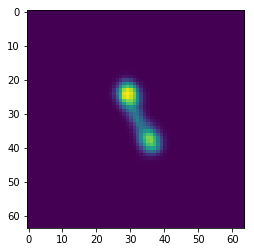

In [22]:
a = 2#19
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
#     e[0][0] = 100
    d = vae.decode(e)
plt.imshow(d.cpu()[0][0])
print(torch.sigmoid(e), l)

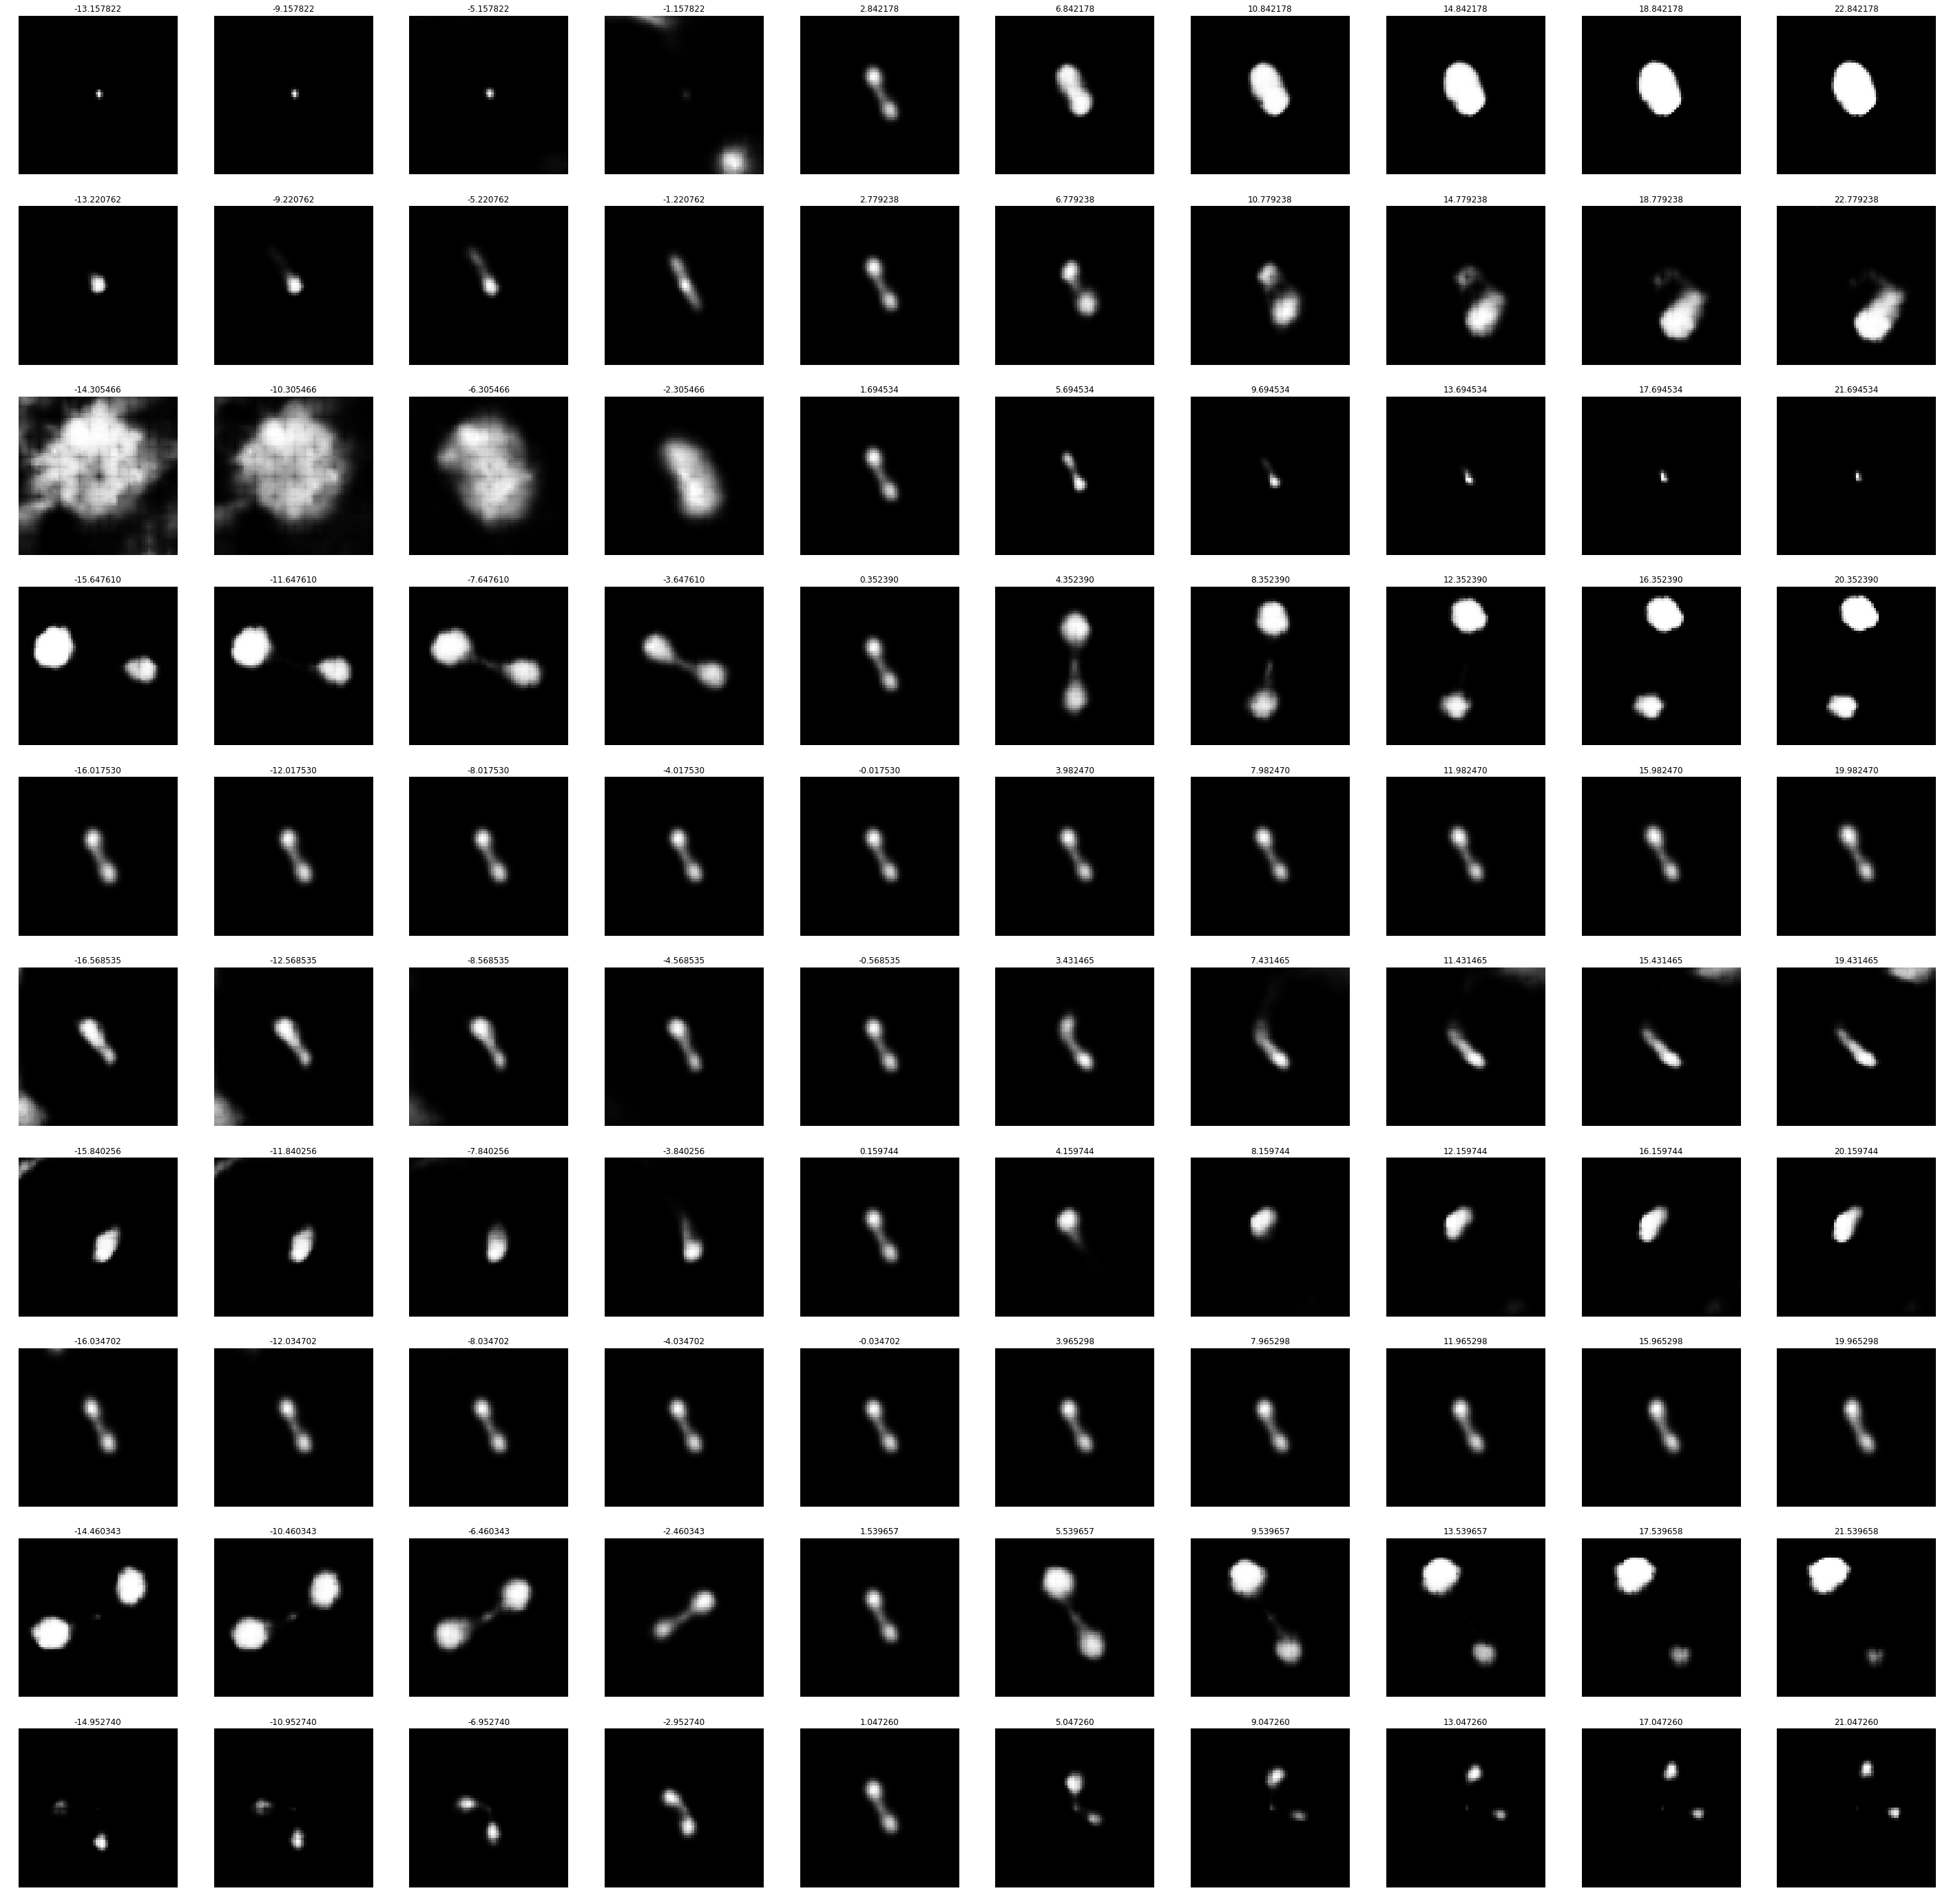

In [23]:
r = 10
nimg = r * 10
k=4
m=1
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = vae.encode(s.to(device))[0]
            v = e[0][i]
            nv = -4*k + v + k*j
            e[0][i] = nv
            d = vae.decode(e).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

In [15]:
torch.sigmoid(e)

tensor([[0.8719, 0.7120, 0.7092, 0.5370, 0.4912, 0.4602, 0.5119, 0.4927, 0.7652,
         1.0000]], device='cuda:0')

In [16]:
e[0][0]

tensor(1.9175, device='cuda:0')

In [17]:
c = sample[1][sample[1] > 1]
c = c[c < 4]
c == 3

tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
       dtype=torch.uint8)

In [18]:
s

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [19]:
sample[1]

tensor([5, 4, 3, 3, 1, 5, 5, 2, 4, 2, 4, 4, 3, 2, 5, 5, 4, 4, 4, 1, 1, 2, 4, 1,
        5, 3, 4, 2, 2, 2, 5, 5, 5, 1, 2, 1, 4, 5, 4, 4, 5, 4, 4, 2, 2, 4, 5, 4,
        4, 6, 1, 4, 4, 1, 3, 6, 6, 4, 5, 4, 4, 2, 4, 2, 4, 1, 4, 4, 6, 1, 2, 4,
        4, 2, 1, 3, 4, 4, 4, 4, 3, 2, 1, 2, 3, 3, 4, 1, 1, 3, 2, 3, 3, 4, 2, 4,
        4, 5, 6, 1, 4, 2, 3, 3, 5, 3, 3, 2, 4, 2, 2, 4, 4, 3, 4, 4, 2, 2, 4, 3,
        2, 2, 3, 1, 5, 3, 1, 4])

Labels of RG types in this work

    1 = compact sources (FR0s are marked as 1F);

    2 = typical FRIs;

    3 = typical FRIIs;

    4 = Bent tailed (BT);

    5 = X-shaped radio galaxies (XRGs);

    6 = Ring-like radio galaxies (RRGs).

In [20]:
vae = torch.load('b_vae_2_model')
vae.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'b_vae_2_model'